In [941]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [942]:
df = pd.read_csv("dataset/data_car.csv")
df.sample(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
9868,Chevrolet,Spark EV,2014,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,27010
4333,Ford,Expedition,2017,regular unleaded,365.0,6.0,AUTOMATIC,rear wheel drive,4.0,NaN,Large,4dr SUV,21,15,5657,63307
1278,Honda,Accord,2017,regular unleaded,185.0,4.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,36,27,2202,30820
7645,Honda,Prelude,2001,premium unleaded (required),200.0,4.0,MANUAL,front wheel drive,2.0,Performance,Compact,Coupe,25,20,2202,23600
3820,Oldsmobile,Eighty-Eight Royale,1995,regular unleaded,205.0,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Large,Sedan,26,17,26,2000


In [943]:
r = list(df["Driven_Wheels"].unique())
print(r)

['rear wheel drive', 'front wheel drive', 'all wheel drive', 'four wheel drive']


In [944]:
len(df)

11914

In [945]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_col = list(df.dtypes[df.dtypes == "object"].index)

for col in string_col:
    df[col] = df[col].str.lower().str.replace(" ", "_")

df.sample()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
2408,volkswagen,cc,2016,premium_unleaded_(recommended),280.0,6.0,automated_manual,all_wheel_drive,4.0,performance,midsize,sedan,25,17,873,44355


In [946]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_fuel_type   11911 non-null  object 
 4   engine_hp          11845 non-null  float64
 5   engine_cylinders   11884 non-null  float64
 6   transmission_type  11914 non-null  object 
 7   driven_wheels      11914 non-null  object 
 8   number_of_doors    11908 non-null  float64
 9   market_category    8172 non-null   object 
 10  vehicle_size       11914 non-null  object 
 11  vehicle_style      11914 non-null  object 
 12  highway_mpg        11914 non-null  int64  
 13  city_mpg           11914 non-null  int64  
 14  popularity         11914 non-null  int64  
 15  msrp               11914 non-null  int64  
dtypes: float64(3), int64(5

<Axes: xlabel='msrp', ylabel='Count'>

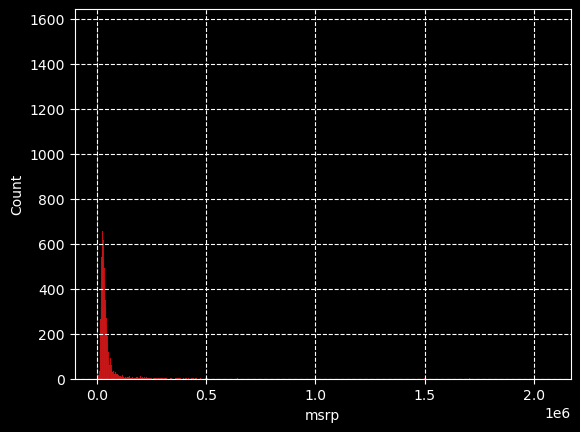

In [948]:
plt.style.use('dark_background')
plt.grid(linestyle='--')
sns.histplot(df.msrp, color="red")


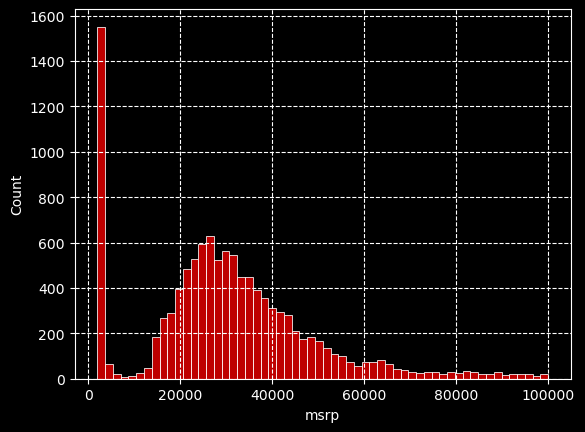

In [949]:
sns.histplot(df.msrp[df.msrp < 100000], color="red")
plt.grid(linestyle='--')

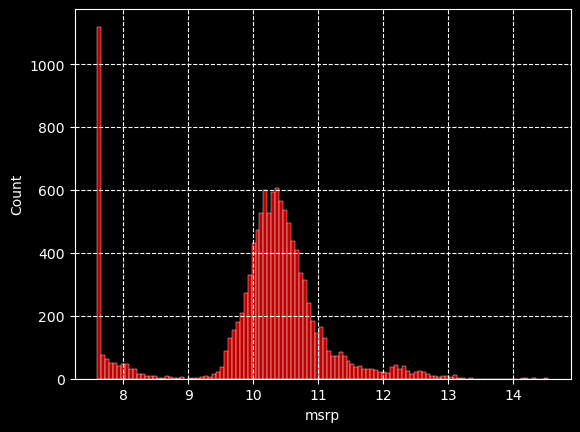

In [950]:
log_price = np.log1p(df.msrp)

sns.histplot(log_price, color="red")
plt.grid(linestyle='--')

In [951]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [952]:
def dataset_partitioning(df):
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    print(n_train, n_test, n_val)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled[:n_train].copy()
    df_test = df_shuffled[n_train: n_train + n_test].copy()
    df_val = df_shuffled[n_train + n_test:].copy()

    return df_train, df_test, df_val


def normalization_target(df_train, df_test, df_val):
    y_train = np.log1p(df_train["msrp"])
    y_test = np.log1p(df_test["msrp"])
    y_val = np.log1p(df_val["msrp"])

    del df_train["msrp"]
    del df_test["msrp"]
    del df_val["msrp"]

    return y_train, y_test, y_val

def make_matrix(df_train, df_test, df_val):
    return df_train.values, df_test.values, df_val.values

In [953]:
base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]
target = ["msrp"]

def train_linear_regression(X: np.array, y, r=0.0):

    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

def prepare_cat_features(df: pd.DataFrame, features: list):
    # cat_features = ["transmission_type", "driven_wheels", "make", "vehicle_size", "number_of_doors", "engine_fuel_type", "vehicle_style", "model"]
    cat_features = ["make",  "model"]
    # df["market_category"].fillna(0)
    new_cols = []
    for cat_feature in cat_features:
        unique_values = list(df[cat_feature].unique())
        for uni_value in unique_values:
            feature = f"{cat_feature}_{uni_value}"
            new_col = (df[cat_feature] == uni_value).astype(int)
            new_col.name = feature
            new_cols.append(new_col)
            features.append(feature)

    new_cols_df = pd.concat(new_cols, axis=1)
    df = pd.concat([df, new_cols_df], axis=1)
    return df, features

def prepare_X(df: pd.DataFrame):
    df = df.copy()
    features = base.copy()

    features_filling = ["number_of_doors", "engine_hp", "engine_cylinders", "engine_fuel_type"]
    df[features_filling] = df[features_filling].fillna(df[features_filling].mode().iloc[0])

    df_cat, features = prepare_cat_features(df, features)

    df_cat["age"] =  2017 - df.year
    features.append("age")
    features.append("msrp")

    df_cat = df_cat[features]
    
    return df_cat


def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    
    return np.sqrt(mse)


In [954]:
df = prepare_X(df)
df_train, df_test, df_val = dataset_partitioning(df)

y_train, y_test, y_val = normalization_target(df_train, df_test, df_val)
X_train, X_test, X_val = make_matrix(df_train, df_test, df_val)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

7150 2382 2382
(7150, 968)
(2382, 968)
(2382, 968)


In [955]:
w_0, w = train_linear_regression(X_train, y_train, r=0.001)

y_pred = w_0 + X_train.dot(w)

In [956]:
y_pred_val = w_0 + X_val.dot(w)
y_pred_test = w_0 + X_test.dot(w)

rmse_val = rmse(y_val, y_pred_val)
rmse_test = rmse(y_test, y_pred_test)
print(f"validation: {round(rmse_val, 2)}")
print(f"test: {round(rmse_test, 2)}")


validation: 0.23
test: 0.24


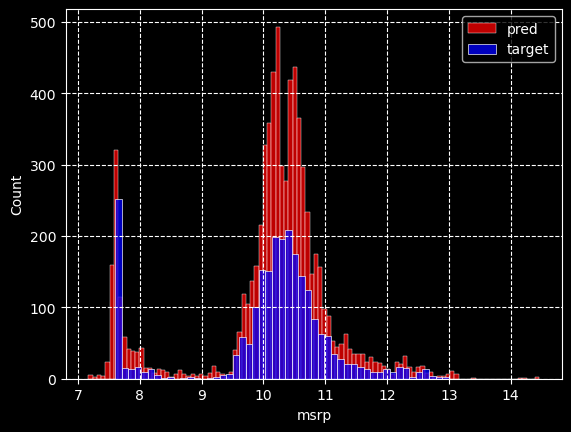

In [998]:
sns.histplot(y_pred, label="pred", color="red")
sns.histplot(y_val, label="target", color="blue")
plt.grid(linestyle='--')
plt.legend()

In [958]:
ad = {
    "city_mpg": 18,
    "transmission_type": "automatic", 
    "driven_wheels": "all_wheel_drive", 
    "make": "toyota", 
    "vehicle_size": "midsize", 
    "number_of_doors": 4.0, 
    "engine_fuel_type": "regular_unleaded", 
    "engine_cylinders": 6.0, 
    "highway_mpg": 25, 
    "popularity": 2031,
    "vehicle_style": "wagon",
    "year": 2013,
    "model": "venza",
    "engine_hp": 268.0,
    "msrp": 1,
}

In [959]:
df_test_one = pd.DataFrame([ad])
df_test_one = prepare_X(df_test_one)

columns=list(df.columns)
empty_df = pd.DataFrame([[0] * len(df.columns)], columns=columns)

selected_columns = df_test_one.columns
empty_df[selected_columns] = df_test_one[selected_columns]
del empty_df["msrp"]


y_pred_one = w_0 + empty_df.values.dot(w)

suggestion = np.expm1(y_pred_one)
print(f"predict_price: {round(suggestion[0], 2)}")

predict_price: 34558.48
